Stage 1 Feature Importances:
          Social Media  Importance
0   facebook_spend_log    0.506446
1     tiktok_spend_log    0.180479
3   snapchat_spend_log    0.166026
2  instagram_spend_log    0.147048


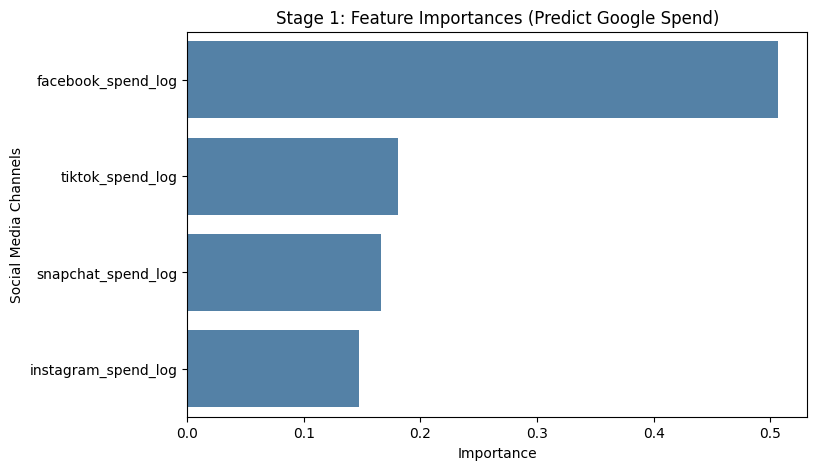

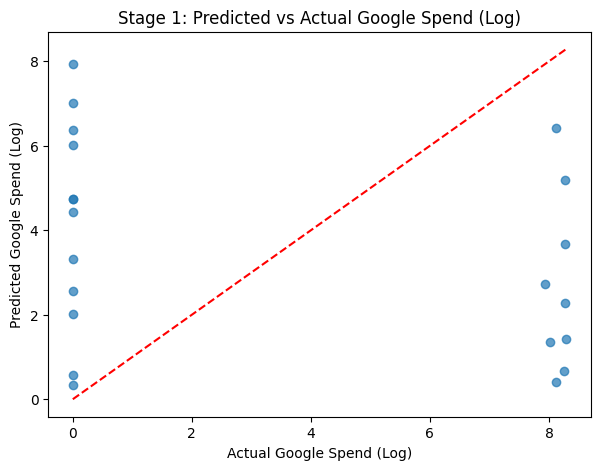

Stage 1 Test RMSE: 5.256209558297386
Stage 1 Test R2: -0.6905294290908512
Stage 1 Feature Importances:
          Social Media  Importance
0   facebook_spend_log    0.506446
1     tiktok_spend_log    0.180479
3   snapchat_spend_log    0.166026
2  instagram_spend_log    0.147048
Stage 2 Train RMSE: 2.0313141848447747 R2: 0.605927275139095
Stage 2 Test RMSE: 2.372356310826054 R2: 0.4219234281110228
Stage 2 Feature Importances:
                Feature  Importance
3  average_price_scaled    0.442593
2            sms_send_k    0.239814
4      followers_growth    0.122801
1         emails_send_k    0.100484
0     google_spend_pred    0.094308


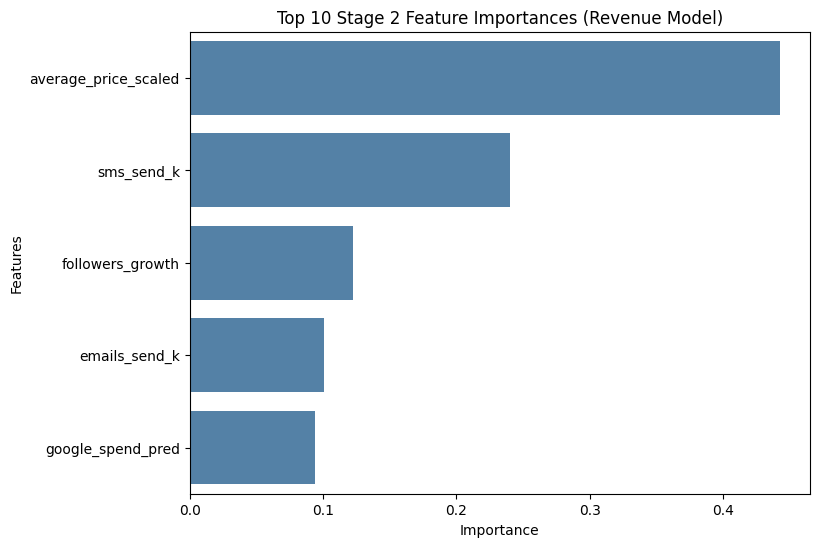

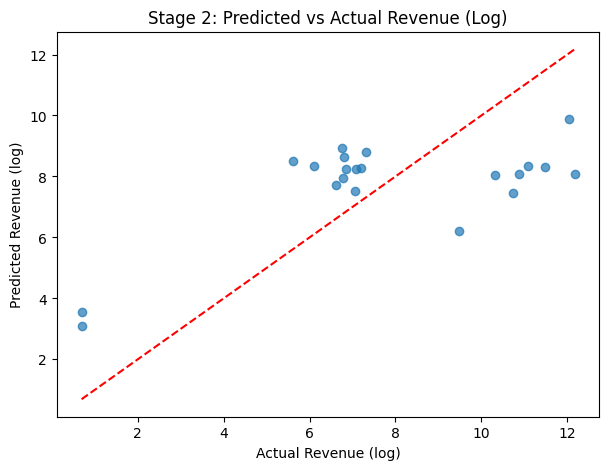

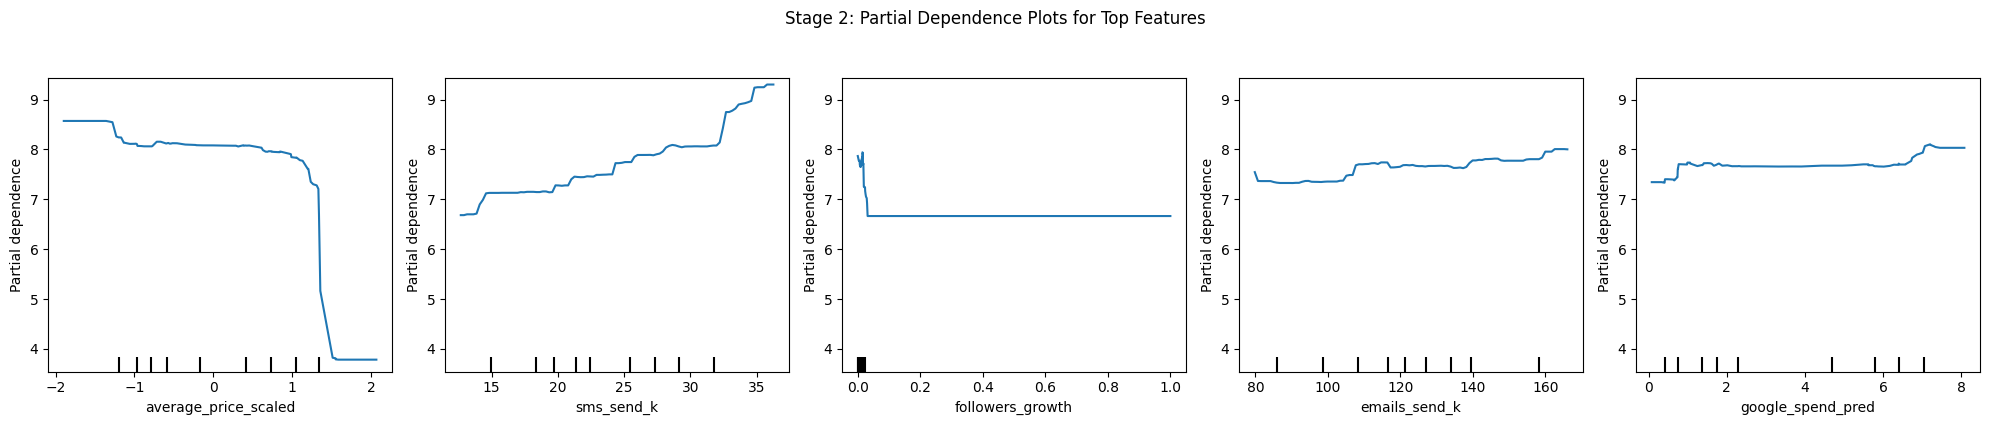

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

# -----------------------------
# Load and preprocess dataset
# -----------------------------
dataset = pd.read_csv('Assessment 2 - MMM Weekly.csv')

# ---- Time features ----
dataset["week"] = pd.to_datetime(dataset["week"])
dataset["week_number"] = (dataset["week"] - dataset["week"].min()).dt.days // 7 + 1
dataset["year"] = dataset["week"].dt.year
dataset["month"] = dataset["week"].dt.month
dataset["quarter"] = dataset["week"].dt.quarter

# ---- Lag features ----
dataset["revenue_lag1"] = dataset["revenue"].shift(1)
dataset["revenue_lag2"] = dataset["revenue"].shift(2)
dataset = dataset.dropna().reset_index(drop=True)

# List of spend variables
spend_vars = ["facebook_spend", "google_spend", "tiktok_spend",
              "instagram_spend", "snapchat_spend"]

# Apply log transform
for col in spend_vars:
    dataset[f"{col}_log"] = np.log1p(dataset[col])
dataset["revenue_log"] = np.log1p(dataset["revenue"])

# ---- Categorical features ----
dataset["promotions_cat"] = dataset["promotions"].astype("category")
if dataset["promotions"].nunique() > 2:
    dataset["promotions_intensity"] = dataset["promotions"]

# ---- Other scaled features ----
dataset["emails_send_k"] = dataset["emails_send"] / 1000
dataset["sms_send_k"] = dataset["sms_send"] / 1000

dataset["followers_lag1"] = dataset["social_followers"].shift(1)
dataset["followers_growth"] = (dataset["social_followers"] - dataset["followers_lag1"]) / dataset["followers_lag1"]
dataset["followers_growth"] = dataset["followers_growth"].fillna(0).clip(-1, 1)

# ---- Feature scaled ----
scaler = StandardScaler()
dataset["followers_growth_scaled"] = scaler.fit_transform(dataset[["followers_growth"]])
dataset["average_price_scaled"] = scaler.fit_transform(dataset[["average_price"]])

# Stage 1: Predict Google spend from social media
X_social = dataset[["facebook_spend_log", "tiktok_spend_log", "instagram_spend_log", "snapchat_spend_log"]]
y_google = dataset["google_spend_log"]

# ---- Time Based Split ----
split_index = int(len(dataset) * 0.8)
X_train, y_train = X_social.iloc[:split_index], y_google.iloc[:split_index]
X_test, y_test = X_social.iloc[split_index:], y_google.iloc[split_index:]

# ---- Trained Using Random Forest Regression ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

dataset["google_spend_pred"] = rf_model.predict(X_social)
y_pred_test = rf_model.predict(X_test)

# ---- Calculating Accuracy ----
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)


feature_importances = pd.DataFrame({
    "Social Media": X_social.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Stage 1 Feature Importances:")
print(feature_importances)

# Stage 1 Plots
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Social Media", data=feature_importances, color="steelblue")
plt.title("Stage 1: Feature Importances (Predict Google Spend)")
plt.xlabel("Importance")
plt.ylabel("Social Media Channels")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Google Spend (Log)")
plt.ylabel("Predicted Google Spend (Log)")
plt.title("Stage 1: Predicted vs Actual Google Spend (Log)")
plt.show()


# Stage 2: Predict Revenue
stage2_features = [
    "google_spend_pred",
    "emails_send_k",
    "sms_send_k",
    "average_price_scaled",
    "followers_growth"
] + [col for col in dataset.columns if col.startswith("promotions_cat_")]

X_stage2 = dataset[stage2_features].copy()
y_stage2 = dataset["revenue_log"].copy()

X_stage2.replace([np.inf, -np.inf], 0, inplace=True)
y_stage2.replace([np.inf, -np.inf], 0, inplace=True)
X_stage2.fillna(0, inplace=True)
y_stage2.fillna(0, inplace=True)

# ---- Time Based Split ----
split_index = int(len(X_stage2) * 0.8)
X_train2, y_train2 = X_stage2.iloc[:split_index], y_stage2.iloc[:split_index]
X_test2, y_test2 = X_stage2.iloc[split_index:], y_stage2.iloc[split_index:]

# ---- Trained Using Random Forest Regression ----
rf_stage2 = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)
rf_stage2.fit(X_train2, y_train2)

y_pred_train2 = rf_stage2.predict(X_train2)
y_pred_test2 = rf_stage2.predict(X_test2)

# ---- Calculating Accuracy ----
rmse_train2 = np.sqrt(mean_squared_error(y_train2, y_pred_train2))
rmse_test2 = np.sqrt(mean_squared_error(y_test2, y_pred_test2))
r2_train2 = r2_score(y_train2, y_pred_train2)
r2_test2 = r2_score(y_test2, y_pred_test2)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Stage 1 Test RMSE:", rmse)
print("Stage 1 Test R2:", r2)

feature_importances = pd.DataFrame({
    "Social Media": X_social.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Stage 1 Feature Importances:")
print(feature_importances)

print("Stage 2 Train RMSE:", rmse_train2, "R2:", r2_train2)
print("Stage 2 Test RMSE:", rmse_test2, "R2:", r2_test2)

importances = pd.DataFrame({
    "Feature": X_stage2.columns,
    "Importance": rf_stage2.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Stage 2 Feature Importances:")
print(importances)

# Stage 2 Plots
# Stage 2: Feature importance (Top 10)
top_features2 = importances.head(10)
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=top_features2, color="steelblue")
plt.title("Top 10 Stage 2 Feature Importances (Revenue Model)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Stage 2: Predicted vs Actual
plt.figure(figsize=(7,5))
plt.scatter(y_test2, y_pred_test2, alpha=0.7)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], "r--")
plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Stage 2: Predicted vs Actual Revenue (Log)")
plt.show()

# Stage 2: Partial Dependence Plots for top 5 features
top5_features = top_features2["Feature"].head(5).tolist()
fig, ax = plt.subplots(1, 5, figsize=(20,4))  # match 5 features
PartialDependenceDisplay.from_estimator(rf_stage2, X_stage2, top5_features, ax=ax)
plt.suptitle("Stage 2: Partial Dependence Plots for Top Features", y=1.05)
plt.tight_layout()
plt.show()




